# Lennard Jones cluster optimization

## Introduction
In computational chemistry, optimizing the arrangement of atomic clusters is crucial for understanding the properties of materials at the molecular level.

Initially inspired by the Au-Pt system proposed in the paper [1], it was soon realized that the Lennard-Jones potential, which is effective for modeling noble gas interactions, was inadequate for accurately modeling metallic interactions. 
Therefore, this project focuses on optimizing Lennard-Jones clusters of Argon (Ar) and Krypton (Kr) instead.

Lennard-Jones potentials are commonly used to model the interaction between a pair of neutral atoms, capturing the balance between attractive and repulsive forces. The optimization of such clusters aims to find the most stable configuration, which corresponds to the global minimum of the potential energy surface.

To accurately model the interatomic distances and interactions, a voxel grid[2] was used. In this context, a voxel grid divides the three-dimensional space into discrete units, known as voxels, with each voxel representing a specific volume element in space measured in angstroms (Å). This method is particularly effective for visualizing and calculating spatial distributions of atoms within a cluster, allowing precise control over atomic positions and distances.

Genetic Algorithm (GA)[3] (invented by John H. Holland in the 1960s) is an heuristic search technique inspired by the principles of natural selection and genetics. 

It iteratively evolves a population of potential cluster configurations through selection, crossover, and mutation processes. By evaluating the fitness of each configuration (that is the the Lennard-Jones potential in this case), the GA progressively leads to the optimal atomic arrangement by performing be above metioned operations.

GA-s tends to be quite good at finding generally good global solutions due to their broad exploration of the surface, but somehow inefficient at finding the last few mutations to find the absolute optimum. 
For this reson, the new proposed approach (GASA) combines the global search capabilities of GA with the local search efficiency of SA.

In addition, all results are cross-validated and compared with calculations from the Tinker's software. 

## Outline
* ####  System configuration
* #### Voxel grid
* #### Genetic algorithm
  * Selection
  * Crossover
  * Mutation
* #### Caveats of GA: the need of a new approach
* #### Simulated Annealing
* #### GASA
* #### Results
* #### Conclusion

### System configuration
The system under consideration consists of a cluster of 30 atoms, randomly arranged with varying amounts of krypton (Kr) and argon (Ar) atoms. 
We will see later why it may be useful to initialize the system in an agnostic way.



## Voxel grid
A voxel grid is a three-dimensional array that represents space divided into discrete, uniform cubes called voxels. 
Is a general tool in various fields, not only in computational chemistry, but also in computer graphics and medical imaging.
In the context of this project, the voxel grid is used to simulate the placement of atoms within a defined space.

The implemented voxel has the size of the biggest atom in the system:  $radius(Kr) = 3.6 $ Å . This is not a constraint of the voxel, however it simplified a lot the data structure: it is possible for a voxel to contain multiple atoms (and is what typically is done when more accuracy is needed, like docking).

Each voxel contains: 0 (no atom in that position) or 1/2 enconding for one of the presence of one of the two types at index$(x, y, z)$. 
A huge advantage of this representation is the capability of working directly with indexes of space.

Moreover, distances are calculates as distance between elements in the grid, and then multiplied by the voxel size ($3.6 Å$), obtaining coherent units of measurment, with an easy mapping from real-world experiments and simulations. 
The structure also implicitly prohibit multiple atoms to stay in same position.

Last but not least, in a discrete space, operations are more efficient than in continuous spaces, working directly with matrix and vectors. 

Being a discretization, however, it will be less accurate than representing atoms only with coordinates.

A box of 36x36x36 Å is chosen, and the system we aim to minimize will be composed of $30$ atoms, allowing a reasonable degrees of freedom for atoms (atom density of $\frac{30}{36*36*36} \approx 0.000643$).

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math 

# Voxel grid parameters
grid_size = 10  # Define the size of the grid
voxel_size = 3.6  # Diameter of the larger atom (Kr)

# Initialize the voxel grid with random placements of atoms
def initialize_grid(grid_size, num_atoms):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)
    atom_positions = []
    atom_types = []  # Track the type of each atom
    for _ in range(num_atoms):
        x, y, z = random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        while grid[x, y, z] != 0:
            x, y, z = random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        grid[x, y, z] = 1  # 1 indicates an atom is present
        atom_positions.append((x, y, z))
        atom_types.append(random.choice(['Ar', 'Kr']))  # Randomly assign Ar or Kr to each position
    return grid, atom_positions, atom_types

## Lennard Jones 12-6

$$V(r) = 4\varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^{6} \right]$$

Where:
* $\epsilon $ is the depth of the potential well
* $\sigma $ is the distance at which the potential is zero


The LJ potential simplifies the system by disregarding important real-world effects like charge transfer, higher-order multipole interactions, and quantum mechanical effects. 

For this reasons LJ is particularly well-suited for noble gases like argon and krypton: i.e. dispersively interacting spherical particles.

In [8]:
# Calculate the distance between two atoms in voxel grid's unit of measurment
def distance(atom1, atom2):
    return np.sqrt(np.sum((np.array(atom1) - np.array(atom2))**2))

# Calculate the Lennard-Jones potential for a pair of atoms
def lennard_jones_potential(r, epsilon, sigma):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

Parameters of the Ar atom lennard jones potential are taken from the LennardJones notebook from White et al work.
An important consideration is that the calculated energy will always be in kcal/mol in this notebook, therefore the $\epsilon$ in the LennardJones notebook must be divided by 4.184 that is the conversion factor from J to cal. 

For Kr atom parameters two ORCA simulation was runned, one with two atoms and one with single Kr atoms, in order to calculate the dissociation energy.

In [3]:
print("------ Input file for Kr-Kr ------")
with open('ORCA parameter calculation for LJ/krkr/krkr.inp', 'r') as f:
    print(f.read())

print("\n\n------ Input file for isolated Kr ------")
with open('ORCA parameter calculation for LJ/kr/kr.inp', 'r') as f:
    print(f.read())

------ Input file for Kr-Kr ------
# MP2 scan of the potential energy curve for Kr...Kr
! MP2 aug-cc-pVTZ TightSCF opt
%geom Scan
      B 0 1 = 2.8, 10.0, 21 # distance that will be scanned
      end
end
* gzmt 0 1
Kr
Kr  1  3.600
*


------ Input file for isolated Kr ------
# MP2 scan of the potential energy curve for Kr
! MP2 aug-cc-pVTZ TightSCF
* gzmt 0 1
Kr
*


Reading the output energies from stored file with results of calculation:

In [2]:
import pandas as pd
scan_out = pd.read_csv("ORCA parameter calculation for LJ/krkr/data_scan_krkr.txt")

In [3]:
E_kr_mp2          = -2752.294114559418 ## SCF

In [6]:
E_krkr_mp2 = (np.array(scan_out["E"])-2*E_kr_mp2)*627.509 

In [15]:
import scipy.optimize as opt

leng_scan = len(scan_out)
popt, pcov   = opt.curve_fit(lennard_jones_potential, np.array(scan_out["r"])[1:], E_krkr_mp2[1:], bounds=([0,3],[1,4]))

epsl = popt[0]
sig = popt[1]

RLJ_orca = np.linspace(scan_out["r"][0],scan_out["r"][len(np.array(scan_out["r"]))-1],500)
ELJ_orca = lennard_jones_potential(RLJ_orca, epsl, sig)

(-2.0, 10.0)

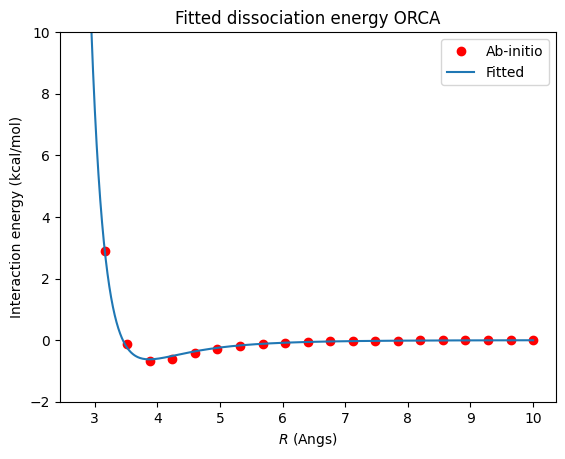

In [16]:
plt.plot(np.array(scan_out["r"]), E_krkr_mp2, "r o", label="Ab-initio" )
plt.plot(RLJ_orca, ELJ_orca, label="Fitted")
plt.legend()
plt.title("Fitted dissociation energy ORCA")
plt.xlabel('$R$ (Angs)')
plt.ylabel('Interaction energy (kcal/mol)')
plt.ylim(-2,10)

In [17]:
print("Fitted values from ab-initio calculation with ORCA:")
print("Epsilon: " + str(epsl))
print("Sigma: " + str(sig))

Fitted values from ab-initio calculation with ORCA:
Epsilon: 0.6238659792453782
Sigma: 3.4488929891122657


[Rutkai et al](https://pubs.acs.org/doi/10.1021/acs.jpclett.2c02004) obtained LJ's parameters by **fitting** to experimental equations of state for **vapor pressure**: \
$\sigma_{Kr} = 3.6274     $ Å \
$\epsilon_{Kr} = 162.58  $ K

Converting $\epsilon$ into kcal/mol:

In [10]:
kB = 1.9872041*10**(-3) ## kcal/molK

162.58*kB

0.3230796425780001

One reason of this difference (as can be seen from plot) is that distances are on a too sparse grid. At the same time, scan of the PES with theory MP2 and aug-cc-pVTZ basis set seemed expensive for my computational resources. 
I tried to run simulation with a denser grid of 80 bond lenghts in ORCA with 18 parallel cores (using MPI), but took more than 3 hours of computation and lot of heat in the month of june due to cooling fan of the computer to perform 40 steps, therefore I interrupted the ab-initio calculation.

Moreover, results from Rutkai's work are obtained by fitting to experimental data with vapor pressure, even though is not the primary factor since also the work from G. Thomaes and R. van Steenwinkel - Nature 1963 Jan 13, reported smaller values of $\epsilon_{Kr} $  (0.335).

We're heavily **overestimating the depth of the well** compared to both experimental values. 
Our fitted potential is computed from the Kr pair, instead the rutkai et al is accounting many-body interactions, considering more energy contributes the energy is higher.

For this reason I decided to take the literature values for the parametrization of the LJ potential, since it allows to interpretate in a more accurate way the resulted minimization conformations obtained by the algorithms.

In [11]:
# LJ parameters for Argon (Ar) and Krypton (Kr)
# 1.045/4.184 =0.2497 kcal/mol converting white et al epsilon value from notebook of the lectures 
LJ_params = {
    'Ar': {'epsilon': 0.2497, 'sigma': 3.345}, 
    'Kr': {'epsilon': 0.3230, 'sigma': 3.6274}
}

For interaction between different atoms, mixed rules are applied, in particular *Lorentz-Berthelot rule*:
$$\sigma_{Ar-Kr} = \frac{\sigma_{Ar} + \sigma_{Kr}}{2}$$

*Berthelot rule*:
$$\epsilon_{Ar-Kr} = \sqrt{\epsilon_{Ar}\epsilon_{Kr}}$$

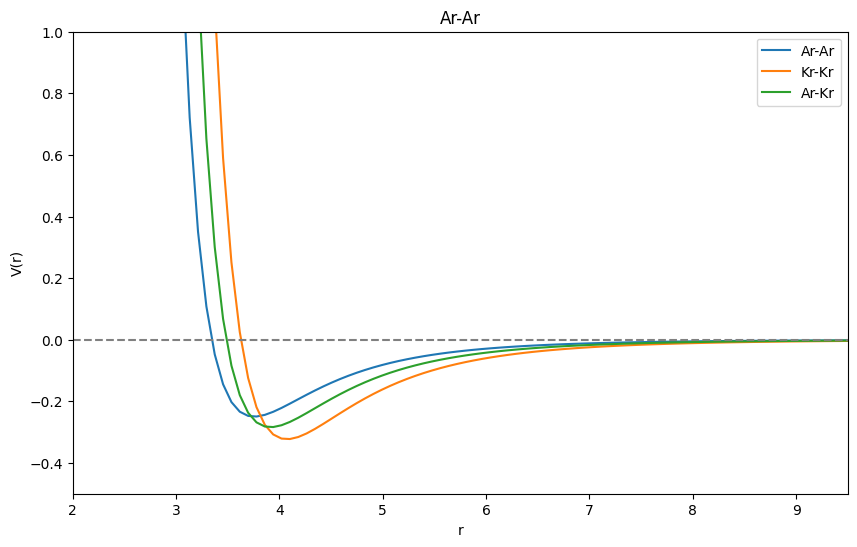

In [16]:
xs = np.linspace(2, 10, 100)
y_ar_ar = []
y_kr_kr = []
y_ar_kr = []
for xx in xs:
    y_ar_ar.append(lennard_jones_potential(xx,LJ_params['Ar']['epsilon'],LJ_params['Ar']['sigma']))
    y_kr_kr.append(lennard_jones_potential(xx,LJ_params['Kr']['epsilon'],LJ_params['Kr']['sigma']))
    y_ar_kr.append(lennard_jones_potential(xx,math.sqrt(LJ_params['Ar']['epsilon']*LJ_params['Kr']['epsilon']),0.5*(LJ_params['Ar']['sigma']+LJ_params['Kr']['sigma'])))
fig = plt.figure(figsize=(10, 6))
plt.plot(xs, y_ar_ar, label='Ar-Ar')
plt.plot(xs, y_kr_kr, label='Kr-Kr')
plt.plot(xs, y_ar_kr, label='Ar-Kr')
plt.axhline(y=0, color='grey', linestyle='--')
plt.xlabel("r")
plt.ylabel("V(r)")
plt.legend()
plt.title("Ar-Ar")
plt.ylim(-0.5,1 )
plt.xlim(2,9.5)
plt.show()

Very small distances (<1e-12) are neglected for numerical issues (even though with voxel grid we avoid those cases).

Cutoff is set to 9 Å by looking at the above plot. **Notice that the function is not differentiable by setting the cutoff in this way**.

What is tipycally done in MD is the use of switch functions in order to keep differentiability of the function. However, the advantage of both my proposed optimization algorithms is that they don't need differentiable functions!

In [22]:
# Calculate the total Lennard-Jones potential for the system
def total_lennard_jones_potential(atom_positions, atom_types, LJ_params, voxel_size):
    total_potential = 0
    for i in range(len(atom_positions)):
        for j in range(i+1, len(atom_positions)):
            r = distance(atom_positions[i], atom_positions[j]) * voxel_size # distance in voxel grid multiplied by voxel size, Å unit of measure
                                                                            # to ensure consistent unit of measure for potential calculation
            if r > 1e-12 and r < 9.:  # Avoid division by zero or extremely small distances and use cutoff
                epsilon_i = LJ_params[atom_types[i]]['epsilon']
                epsilon_j = LJ_params[atom_types[j]]['epsilon']
                if epsilon_i == epsilon_j:
                    sigma = LJ_params[atom_types[i]]['sigma']
                    epsilon = epsilon_i
                else:
                    epsilon = math.sqrt(epsilon_i*epsilon_j)
                    sigma = 0.5*(LJ_params['Ar']['sigma']+LJ_params['Kr']['sigma'])
                total_potential += lennard_jones_potential(r, epsilon, sigma)
    return total_potential

#### Comparing the Ar $B_2$ with experimental values
Is the first term in a series expansion that decribes deviations of the equation of state of real gas from ideal gas.

Is a measure of the interaction between pairs of molecules in a gas, providing insight into the non-ideal behavior of the gas. 


$$B_2(T) = \frac{1}{2} \int_0^\infty \left( 1 - \exp\left(-\frac{U(R)}{RT}\right) \right) 4 \pi R^2 dR $$

In [5]:
def B2iLJ(r, sigma, epsilon, T):
    """Computes the integrand of the B2 coefficient for the LJ potential"""
    eps = 4.184*epsilon # from kcal to kJ
    Rgas = 8.3144626*10**(-3)   # in kJ/(mol K)
    U = lennard_jones_potential(r, eps, sigma)
    integrand = ( 1 - np.exp(-U /(Rgas*T)) ) * 2*np.pi*r**2
    return integrand
    
R = np.linspace(0.00001,20,200)

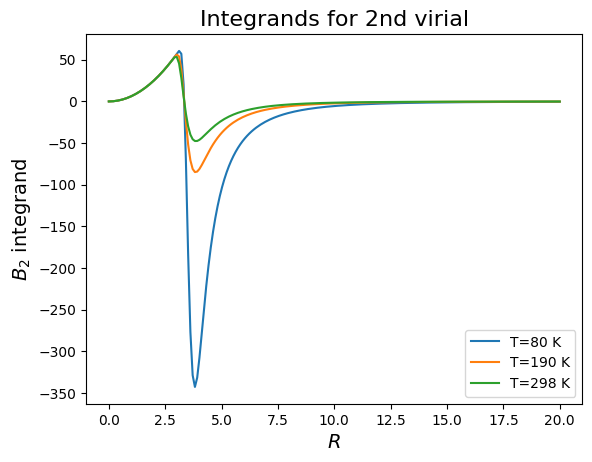

In [7]:
T = 80
int80 = B2iLJ(R,LJ_params["Ar"]["sigma"], LJ_params["Ar"]["epsilon"], T)
T = 190
int190 = B2iLJ(R,LJ_params["Ar"]["sigma"],LJ_params["Ar"]["epsilon"], T)
T = 298
int298 = B2iLJ(R,LJ_params["Ar"]["sigma"],LJ_params["Ar"]["epsilon"], T)

plt.plot(R, int80,  label="T=80 K")
plt.plot(R, int190, label="T=190 K")
plt.plot(R, int298, label="T=298 K")

plt.xlabel('$R$', size=14)
plt.ylabel('$B_2$ integrand', size=14)
plt.title('Integrands for 2nd virial', size=16)
plt.legend()

The deeper **negative peak** at **low temperatures** shows up because molecules have **low kinetic energy**, so, attractive forces dominate.

At higher temperatures, the kinetic energy of the molecules overcomes the attractive forces, making the interaction more repulsive.

To recap: lower temperatures enhance the attractive forces, leading to negative integrands, while higher temperatures mitigate these attractions, resulting in less negative or even positive integrands.

In [26]:
T = np.array( [80.43, 81.95, 84.23, 87.12, 88.85, 92.78, 94.75, 97.65, \
    102.08, 105.89, 108.87, 120.00, 129.56, 144.60, 146.05, 157.41, 190.52] )
B2_ref = np.array( [-0.2851, -0.2729, -0.2685, -0.2459, -0.2359, -0.2169, -0.20730, \
      -0.19485, -0.17910, -0.16782, -0.16154, -0.13425, -0.11493, -0.09318, \
      -0.09208, -0.08034, -0.05285] )

In [52]:
import scipy.integrate as inte
s = LJ_params["Ar"]["sigma"]
e = LJ_params["Ar"]["epsilon"]

ar_b2_obtained = []
for t in range(len(T)):
    b2_integrated = inte.quad(B2iLJ, 0, np.inf, args=(s, e, T[t]))[0]/1000
    print("\t \t Temperature " + str(T[t]) + "\nCalulated B2 = \t\t" + str(b2_integrated)) 
    print("Experimental B2 = \t " + str(B2_ref[t]))
    print("Percentage difference" + "\t " + str(np.abs(b2_integrated-B2_ref[t])*100) + " %")
    print("\n")
    ar_b2_obtained.append(b2_integrated)

	 	 Temperature 80.43
Calulated B2 = 		-0.43247235098886305
Experimental B2 = 	 -0.2851
Percentage difference	 14.737235098886304 %


	 	 Temperature 81.95
Calulated B2 = 		-0.418293022203642
Experimental B2 = 	 -0.2729
Percentage difference	 14.539302220364203 %


	 	 Temperature 84.23
Calulated B2 = 		-0.3984427666724789
Experimental B2 = 	 -0.2685
Percentage difference	 12.99427666724789 %


	 	 Temperature 87.12
Calulated B2 = 		-0.37545962715824177
Experimental B2 = 	 -0.2459
Percentage difference	 12.955962715824176 %


	 	 Temperature 88.85
Calulated B2 = 		-0.3627379981949573
Experimental B2 = 	 -0.2359
Percentage difference	 12.683799819495729 %


	 	 Temperature 92.78
Calulated B2 = 		-0.33635095306774704
Experimental B2 = 	 -0.2169
Percentage difference	 11.945095306774704 %


	 	 Temperature 94.75
Calulated B2 = 		-0.32428956949232074
Experimental B2 = 	 -0.2073
Percentage difference	 11.698956949232073 %


	 	 Temperature 97.65
Calulated B2 = 		-0.3077747896514266
Experime

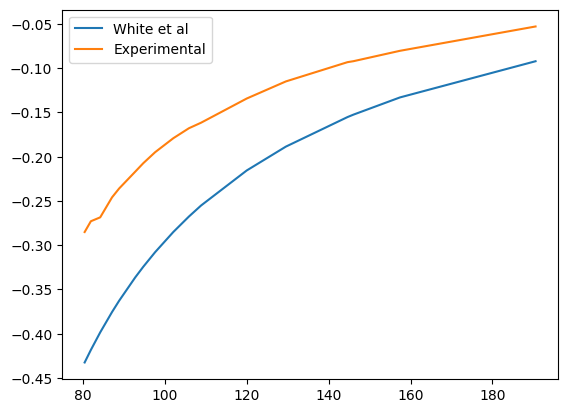

In [62]:
plt.plot(T, ar_b2_obtained , label="White et al")
plt.plot(T,B2_ref, label="Experimental")
plt.legend()

Attractive forces between the particles using white et al's parameters are weaker than those observed experimentally, particularly at low temperatures.
I suppose that at higher tempereratures (like 298.15) those values get closer by looking at the trend.

In light of this, our algorithm will be tested on minimizing system at room temperature environment, or at least interpretation of the algorithm's results are resonable at not low temperatures range.

Same analysis for Kr wasn't done due to less literatures values available. Also, available data weren't in according each other too, leaving lots of uncertainty on which one to chose.

## 2. Genetic algorithm
A genetic algorithm (GA) is a search heuristic that mimics the process of natural selection. It is used to find approximate solutions to optimization and search problems. GAs are particularly useful for problems where the search space is large and the landscape is complex.

Can be applied to a wide range of optimization problems, including:
* Function Optimization
* Combinatorial Optimization: (like the traveling salesman problem, scheduling and many more...).
* Machine Learning: hyperparameters optimization, feature selection.



### 2.1 A generic GA for optimization problems
A population of candidate solutions (called *initial population*) is evolved toward better solutions. Each candidate solution has a set of properties (called from now on **genome**) that are mutated. 
The evolution typically starts from a population of randomly generated individuals (however is not a constraint of the algorithm, the initial population can be constrained to any structure), and is an iterative process, with the populations in each iteration called a generation. 

In each generation, the fitness of every individual in the population is evaluated (the fitness is the value of the objective function in the optimization problem being solved). 
**Individuals with "better" fit are more likely to be selected** from the current population, **their genome is modified** (randomly mutated with genetic operators, like *crossover* and *mutation*) **to form a new generation**. The new generation of candidate solutions is then used in the next iteration of the algorithm. 

The stopping criteria can either be a maximum number of generations has been produced, or a satisfactory fitness level.
[6]
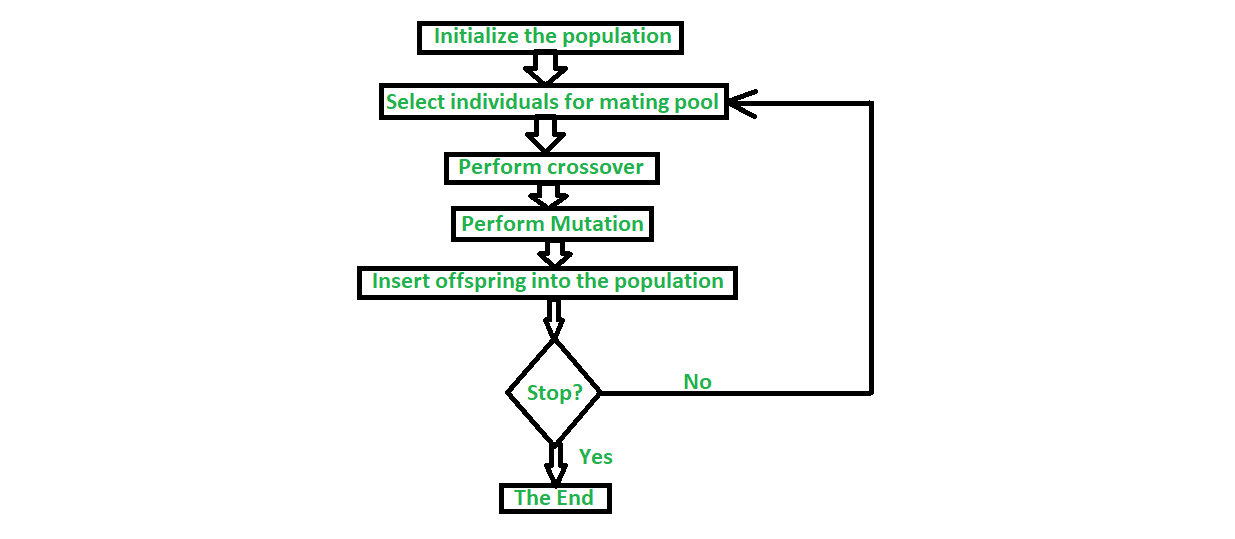

#### 2.1.1 Crossover Operator
Crossover is used to **combine the genetic information of two parents to generate new offspring**. 

Consists in stochastically generating new solutions from an existing population (that are individuals with best fit), and is **analogous to** the crossover that happens during **sexual reproduction** in biology. 
Solutions can also be generated by cloning an existing solution, which is analogous to asexual reproduction. However, typical crossover try to explore the solution space, indeed, common strategies [7] are:
* **One-point crossover**: a **random point** is **selected on the chromosomes of both parents**, known as the **crossover point**. The segments of the chromosomes to the right of this point are exchanged between the two parents. This process produces two offspring, each inheriting a combination of genetic material from both parents.
 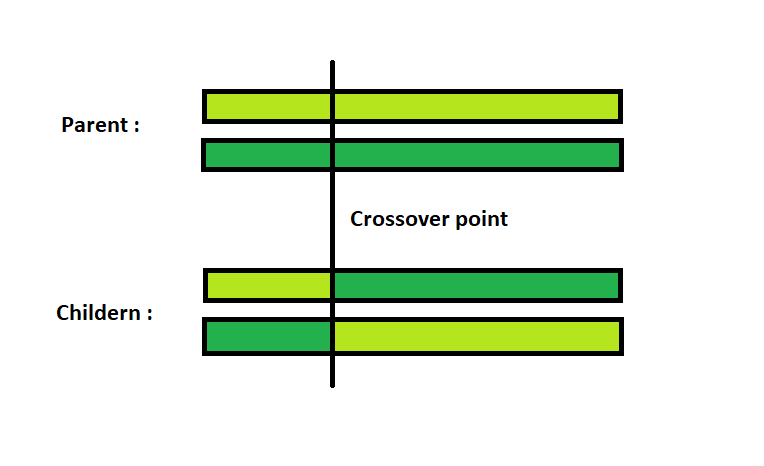
* **Two-point crossover**: two random points are chosen on the parent chromosomes. The segments between these two points are exchanged between the parents. Is equivalent to performing two single-point crossovers at different points on the chromosomes.
* Uniform crossover: each point is chosen from one of the parents with equal probability. Any probability can be used, resulting in offspring which inherit more genetic information from one parent than the other. A flip of a coin for each chromosome is done to decide if it will be included in the off-spring. 
#### 2.1.2 Mutation Operator
Newly generated solutions from the crossover may be mutated before being added to the population. 
Is used to maintain **genetic diversity** of the chromosomes of a population. Is the analogous of biological mutation. 
Stochastically, each gene can be flipped (in case of a two-type system) or mutated with any other type present in the system in a more general way.


A typical genetic algorithm requires:
* a genetic representation of the solution domain: what is the genome (features of the solution)?
* a fitness function to evaluate the solution domain





### 2.2 GA for LJ cluster optimization
Due to the nature of the problem, cluster optimization can be easily mapped to a genetic representation: starting from a candidate of randomly disposed clusters, the ones with best fits are selected. The genome, in this case, are:
* the coordinates, that are changed in order to arrange the structure and arrive to minimal configuration energy
* the atom types, that are mutated in order to find the optimal proportion of atoms


**Crossover is performed on atom's coordinate of the two parent clusters** (randomly) **selected**. 
In this project was implemented a one-point crossover mutation, considering as the crossover point the index of the atoms's disposition.

The mutation occours with a certain probability and is a simple swap between Ar and Kr types.

In [18]:
# Genetic Algorithm for optimization
def genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size, num_generations=500, population_size=20):
    # Initialize population
    population = [initialize_grid(grid_size, num_atoms) for _ in range(population_size)]
    history_evolution = []
    
    for generation in range(num_generations):

        # Calculate fitness
        fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]

        # Selection
        fitness_population = sorted(zip(fitness, population), key=lambda x: x[0])
        population = [x[1] for x in fitness_population[:population_size//sp]]
        if generation % 10 == 0:
            history_evolution.append(population[0])
        
        # Crossover
        new_population = population[:]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            crossover_point = random.randint(0, num_atoms-1)
            child_positions = parent1[1][:crossover_point] + parent2[1][crossover_point:]
            child_types = parent1[2][:crossover_point] + parent2[2][crossover_point:]
            new_population.append((None, child_positions, child_types))
        
        # Mutation
        for individual in new_population:
            if random.random() < m:  # Mutation probability
                idx = random.randint(0, num_atoms-1)
                individual[1][idx] = (random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1))
                individual[2][idx] = random.choice(['Ar', 'Kr'])  # Randomly assign new type
        
        population = new_population
    
    # Get the best solution
    fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]
    best_solution = population[np.argmin(fitness)]

    return best_solution[1], best_solution[2], np.min(fitness), history_evolution

#### 2.2.1 Choice of parameters
GA's performances are heavily parameter dependent. They are assessed through cross validation via grid search for the probability mutation and selection percentage, while the amount of clusters was fixed to 20 due to the amount of computational resources available (greater number of candidates imply broader exploration of PES, and typically a sooner convergence, however a significant amount of time is needed to evaluate lennard jones for several clusters: $O(mn^2)$ where $m$ is the amount of clusters and $n$ the number of atoms). 

The "better" solution is only in comparison to other solutions. As a result, the stopping criterion is not easy to assess. 
Has been fixed to 500 iterations since showed a Plateau in the range [450, 600], may due optimization being stuck into a local minima.

In [575]:
num_atoms = 30
mutation_probabilities = [0.05, 0.1, 0.15, 0.2]
selection_percentages  = [2, 3]
histories = []
for m in mutation_probabilities:
    for sp in selection_percentages:
        random.seed(119)
        best_positions, best_types, best_fitness, history_evolution = genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size)
        histories.append(history_evolution)
        print(f"Mutation probability {m}, selection percentage {sp}, fitness: {best_fitness}")


Mutation probability 0.05, selection percentage 2, fitness: -11.677919197516518
Mutation probability 0.05, selection percentage 3, fitness: -8.836087144712863
Mutation probability 0.1, selection percentage 2, fitness: -16.909826658872184
Mutation probability 0.1, selection percentage 3, fitness: -13.998262261897992
Mutation probability 0.15, selection percentage 2, fitness: -21.000179864451127
Mutation probability 0.15, selection percentage 3, fitness: -23.71935090930069
Mutation probability 0.2, selection percentage 2, fitness: -25.75520785980119
Mutation probability 0.2, selection percentage 3, fitness: -23.013025763699503


The lowest energy configuration found is with *probability of mutation = 20%*  and by chosing *1/2* of the original generation size at each iteration.

However, after some tests, was find out that *probability of mutation* = 20% may be too much, and was changing too much atoms, ending up in cluster mostly formed by Kr, since has the lowest LJ function's values (the depth of the well is lower than the one of Ar). A good compromise was found out to be 15%.

In [20]:
mutation_probability = 0.15
selection_percentage = 3   # 1/3 are selected

Rewritten the algorithm in order to store on file the best configurations every 10 steps to make gifs later.

In [31]:
ar_nums = []
kr_nums = []
# Genetic Algorithm for optimization
def genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size, num_generations=500, population_size=20, version=0, folder_name = "pickles_GA/iteration"):
    # Initialize population
    population = [initialize_grid(grid_size, num_atoms) for _ in range(population_size)]
    history_evolution = []
    
    for generation in range(num_generations):

        # Calculate fitness
        fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]

        # Selection
        fitness_population = sorted(zip(fitness, population), key=lambda x: x[0])
        population = [x[1] for x in fitness_population[:population_size//selection_percentage]]
        if generation % 10 == 0:
            print("generation {}: fitness: {}".format(generation, min(fitness)))
            history_evolution.append(population[0])
            pop_npy = np.array(population[0],dtype= object)
            if version == 0:
                np.save(folder_name+ str(generation), pop_npy)
            else:
                np.save("pickles_probcross/iteration"+ str(generation), pop_npy)
        ar_nums.append(population[0][2].count("Ar"))
        kr_nums.append(population[0][2].count("Kr"))
                
        
        # Crossover
        new_population = population[:]
        # crossover version 1
        if version == 0:
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(population, 2)
                crossover_point = random.randint(0, num_atoms-1)
                child_positions = parent1[1][:crossover_point] + parent2[1][crossover_point:]
                child_types = parent1[2][:crossover_point] + parent2[2][crossover_point:]
                new_population.append((None, child_positions, child_types))
        else: # crossover version 2
            alpha = []
            for p in range(len(population)):
                alpha.append(fitness[p])
            alpha = alpha / sum(alpha)
            
            while len(new_population) < population_size:
                parent1, parent2 = random.choices(population,
                                                  weights = alpha, 
                                                  k = 2)
                crossover_point = random.randint(0, num_atoms-1)
                child_positions = parent1[1][:crossover_point] + parent2[1][crossover_point:]
                child_types = parent1[2][:crossover_point] + parent2[2][crossover_point:]
                new_population.append((None, child_positions, child_types))
            
        
        # Mutation
        for individual in new_population:
            if random.random() < mutation_probability:  # Mutation probability
                idx = random.randint(0, num_atoms-1)
                individual[1][idx] = (random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1))
                individual[2][idx] = random.choice(['Ar', 'Kr'])  # Randomly assign new type
        
        population = new_population

    
    # Get the best solution
    fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]
    best_solution = population[np.argmin(fitness)]

    return best_solution[1], best_solution[2], np.min(fitness), history_evolution
random.seed(119)
num_atoms = 30
best_positions, best_types, best_fitness, history_evolution = genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size)
print(f"Best solution: {best_positions}")
print(f"Atom types: {best_types}")
print(f"Best Lennard-Jones potential: {best_fitness}")

generation 0: fitness: -1.5412806195268969
generation 10: fitness: -2.926713487050179
generation 20: fitness: -3.9202068423254652
generation 30: fitness: -5.358005407100533
generation 40: fitness: -5.612210374649952
generation 50: fitness: -5.896182506159425
generation 60: fitness: -5.943874965864774
generation 70: fitness: -6.277539164090908
generation 80: fitness: -6.4440564254596095
generation 90: fitness: -6.49679169381129
generation 100: fitness: -6.559033153270023
generation 110: fitness: -7.88848477529717
generation 120: fitness: -8.677685516188893
generation 130: fitness: -8.693740465866837
generation 140: fitness: -8.828627531902617
generation 150: fitness: -9.376258451047942
generation 160: fitness: -9.529559398157279
generation 170: fitness: -10.09236087434542
generation 180: fitness: -11.304985964765606
generation 190: fitness: -11.857546960997725
generation 200: fitness: -13.042504661693268
generation 210: fitness: -13.840645438304476
generation 220: fitness: -14.544682980

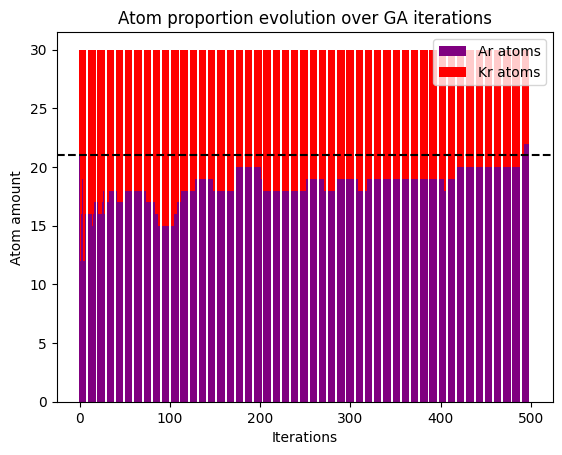

In [24]:
# X-axis positions
x = np.arange(len(ar_nums))

# Plotting the bar plot
fig, ax = plt.subplots()

ax.bar(x, ar_nums, label='Ar atoms', color = "purple")

ax.bar(x, kr_nums, bottom=ar_nums, label='Kr atoms', color = "red")

ax.set_ylabel('Atom amount')
ax.set_xlabel("Iterations")
ax.set_title('Atom proportion evolution over GA iterations')
ax.legend()
ax.axhline(y=ar_nums[0],linestyle='--',c="black")

At initial iterations the algorithm is exploring a lot the search space, doing several mutations trying to minimize the LJ potential.

Indeed, initial configuration is completely random, and most of the reducement is done by mutations prefering Kr atoms due to their lower $\epsilon$ (depth well). Initial crossover start to change positions of each cluster, but not enough energy change is caused with respect to an atom mutation (since positions are still too randomic and very far, and in LJ far position atoms have 0 energy!).

As soon as crossover start to impact positions in a consididerable way, minimizing effectively energy, mutations tends to be more constant, in some way compensating themselves.


Zooming on the first 40 iterations:

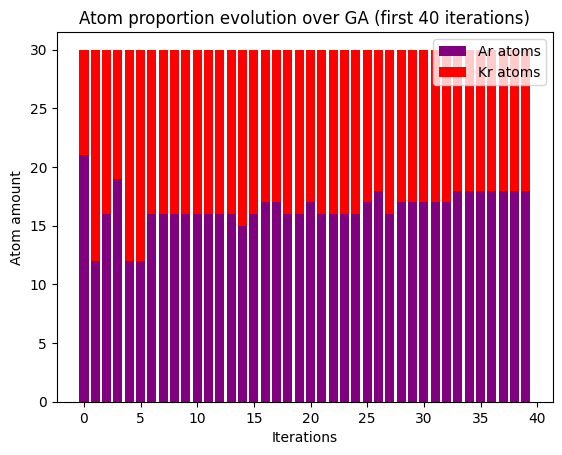

In [25]:
# X-axis positions
x = np.arange(40)

# Plotting the bar plot
fig, ax = plt.subplots()

ax.bar(x, ar_nums[:40], label='Ar atoms', color = "purple")

ax.bar(x, kr_nums[:40], bottom=ar_nums[:40], label='Kr atoms', color = "red")

ax.set_ylabel('Atom amount')
ax.set_xlabel("Iterations")
ax.set_title('Atom proportion evolution over GA (first 40 iterations)')
ax.legend()

This allowed to understand that the initial configuration of the system must be balanced: we can't initialize the system with 90% Kr and 10% Ar (or the opposite), otherwise will converge to a system mostly with one of the two types of atoms, which may be not useful from a interpretational POV.

A utility function to plot atoms on the grid and save to image file

In [26]:
# Plot the atom disposition in a 3D scatter plot
def plot_atom_save(atom_positions, atom_types, grid_size,fn, dim_sphere = 150,title="Optimized structure by GA"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim([0, grid_size])
    ax.set_ylim([0, grid_size])
    ax.set_zlim([0, grid_size])
    
    x_coords_Ar = [pos[0] for pos, t in zip(atom_positions, atom_types) if t == 'Ar']
    y_coords_Ar = [pos[1] for pos, t in zip(atom_positions, atom_types) if t == 'Ar']
    z_coords_Ar = [pos[2] for pos, t in zip(atom_positions, atom_types) if t == 'Ar']
    
    x_coords_Kr = [pos[0] for pos, t in zip(atom_positions, atom_types) if t == 'Kr']
    y_coords_Kr = [pos[1] for pos, t in zip(atom_positions, atom_types) if t == 'Kr']
    z_coords_Kr = [pos[2] for pos, t in zip(atom_positions, atom_types) if t == 'Kr']
    
    ax.scatter(x_coords_Ar, y_coords_Ar, z_coords_Ar, c='purple', s=dim_sphere, label='Ar')
    ax.scatter(x_coords_Kr, y_coords_Kr, z_coords_Kr, c='r', s=dim_sphere, label='Kr')
    ax.set_title(title)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.savefig(fn)
    plt.show()

In [ ]:
for i in range(0,500,10):
    gen = np.load("pickles_GA/iteration" + str(i) + ".npy",allow_pickle=True)
    plot_atom_save(gen[1], gen[2],grid_size, "images_new/iteration" + str(i) + ".png")

Text(0.5, 1.0, 'LJ minimization by GA')

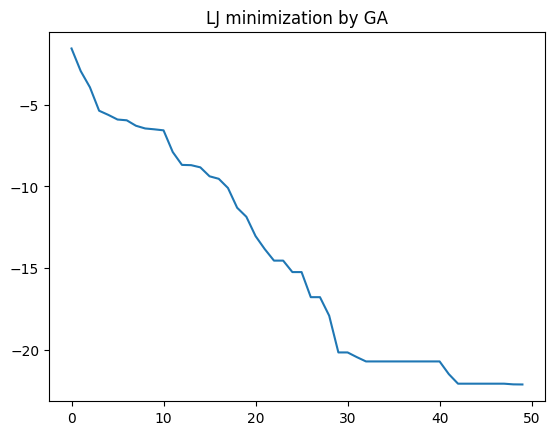

In [39]:
plt.plot(history_evol_noprob)
plt.title("LJ minimization by GA")

The optimization is stucked in a global minima, as the Plateau is showing. 

New strategies are adopted to have a more exploitative algorithm, instead of increasing the computations.

### Selecting parents policy
We now select parents for the offspring with a probability proportional to their fitness: **clusters with higher fitness have a greater likelihood of being chosen as parents**. [6] This approach is reasonable from an evolutionary POV and represent natural selection.

For example, consider a population of animals in the wild. In nature, healthier and stronger animals (those with higher fitness) are more likely to survive, reproduce, and pass on their genes to the next generation. This increases the chances of their offspring inheriting advantageous traits, thereby improving the overall fitness of the population over time. Similarly, in our algorithm, clusters that demonstrate higher fitness are more likely to be selected to contribute to the next generation, enhancing the overall quality of the clusters in subsequent iterations.

This strategy should escape from the local minima in which the GA is being stucked in final iterations, eventually changing sooner the direction of minimization.

In [32]:
ar_nums = []
kr_nums = []
random.seed(119)
num_atoms = 30
best_positions, best_types, best_fitness, history_evolution = genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size,version=1)
print(f"Best solution: {best_positions}")
print(f"Atom types: {best_types}")
print(f"Best Lennard-Jones potential: {best_fitness}")

generation 0: fitness: -1.5412806195268969
generation 10: fitness: -2.776883535551755
generation 20: fitness: -3.5001192681954856
generation 30: fitness: -3.9365772622655077
generation 40: fitness: -4.464979948876554
generation 50: fitness: -4.621069383950369
generation 60: fitness: -5.104942583986074
generation 70: fitness: -5.653473928374882
generation 80: fitness: -6.18866314686055
generation 90: fitness: -6.2139295684642075
generation 100: fitness: -6.3812244501340505
generation 110: fitness: -6.796761047331112
generation 120: fitness: -6.802651032192784
generation 130: fitness: -8.307054145114877
generation 140: fitness: -9.337090497879814
generation 150: fitness: -9.396228421021998
generation 160: fitness: -9.396228421021998
generation 170: fitness: -10.99996316144807
generation 180: fitness: -11.556650008874474
generation 190: fitness: -13.711961016926642
generation 200: fitness: -14.520956404019175
generation 210: fitness: -14.86724504311283
generation 220: fitness: -15.8447743

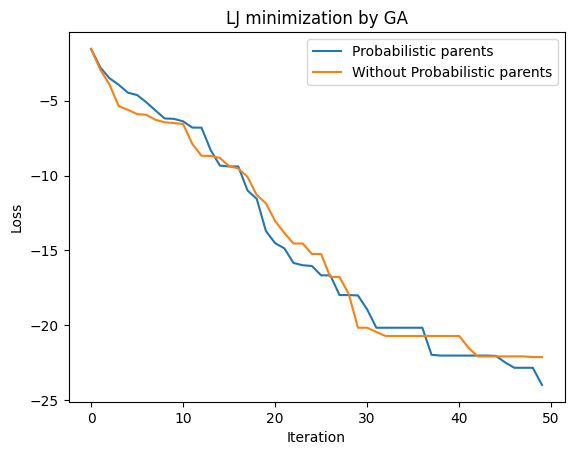

In [37]:
plt.plot(history_evolution, label='Probabilistic parents')
plt.plot(history_evol_noprob, label='Without Probabilistic parents')

plt.title("LJ minimization by GA")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()

We see a similar behaviour when chosing completely random the parents. However in final iterations we can see that the plateau happening in the completely random strategy is now stooped earlier to favour a decreasing loss function. 

In [591]:
from scipy.stats import shapiro 
from scipy.stats import wilcoxon

shapiro(history_evolution[1:])
shapiro(history_evol_noprob[1:])
# no normality -> can't use shapiro -> Wilcoxon test

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(history_evolution, history_evol_noprob)

print(f"Paired t-test statistic: {statistic}, p-value: {p_value}")


Paired t-test statistic: 541.0, p-value: 0.4768698817209719


The two variants of the algorithm are comparable in the sense of mean loss function, there isn't enough evidence to say that chosing parents with probability based on their fitness lead to higher change to reach the minimum. 

In [592]:
import scipy.stats as stats
mean_algo1 = np.mean(history_evolution)
mean_algo2 = np.mean(history_evol_noprob)
# Standard errors
se_algo1 = stats.sem(history_evolution)
se_algo2 = stats.sem(history_evol_noprob)

# 95% confidence intervals
ci_algo1 = se_algo1 * stats.t.ppf((1 + 0.9) / 2., len(history_evolution)-1)
ci_algo2 = se_algo2 * stats.t.ppf((1 + 0.9) / 2., len(history_evol_noprob)-1)

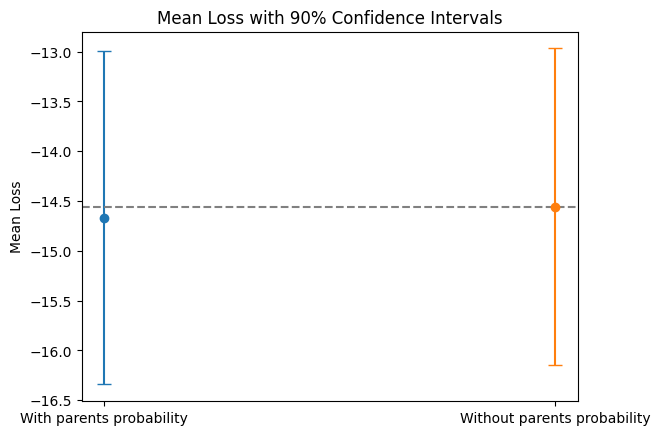

In [593]:
plt.errorbar(1, mean_algo1, yerr=ci_algo1, fmt='o', label='Algorithm 1', capsize=5)
plt.errorbar(2, mean_algo2, yerr=ci_algo2, fmt='o', label='Algorithm 2', capsize=5)

plt.title('Mean Loss with 90% Confidence Intervals')
plt.ylabel('Mean Loss')
plt.xticks([1, 2], ['With parents probability', 'Without parents probability'])
plt.axhline(y=mean_algo2, color='grey', linestyle='--')
plt.show()

Using same number of iterations the mean energy found at each iteration is comparable, however, if we'd run the algorithm for more iterations we expect a lower mean loss when chosing the probability based parenting.

In [ ]:
for i in range(0,500,10):
    gen = np.load("pickles_probcross/iteration" + str(i) + ".npy",allow_pickle=True)
    plot_atom_save(gen[1], gen[2],grid_size, "images_new_probcross/iteration" + str(i) + ".png",150,"Optimized structure by GA with parent policy")

Some utility functions for gifs generation.

In [46]:
import re
from PIL import Image
import imageio
import os

def numerical_sort(value):
    """Helper function to sort filenames numerically."""
    numbers = re.findall(r'\d+', value)
    return int(numbers[0]) if numbers else value

def create_gif(image_folder, output_path, duration=0.5):
    images = []
    
    # Get all image files from the folder and sort them numerically
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
    image_files.sort(key=numerical_sort)
    
    # Read images into a list
    for file_name in image_files:
        file_path = os.path.join(image_folder, file_name)
        images.append(imageio.v2.imread(file_path))    
    # Create and save the GIF
    imageio.mimsave(output_path, images, duration=duration)
    print(f"GIF created and saved at {output_path}")


In [82]:
image_folder = 'images_new_probcross'
output_path = 'probcross.gif'    
create_gif(image_folder, output_path)

GIF created and saved at probcross.gif


In [20]:
image_folder = 'images_new'  
output_path = 'GA no prob.gif'     
create_gif(image_folder, output_path)

GIF created and saved at GA no prob.gif


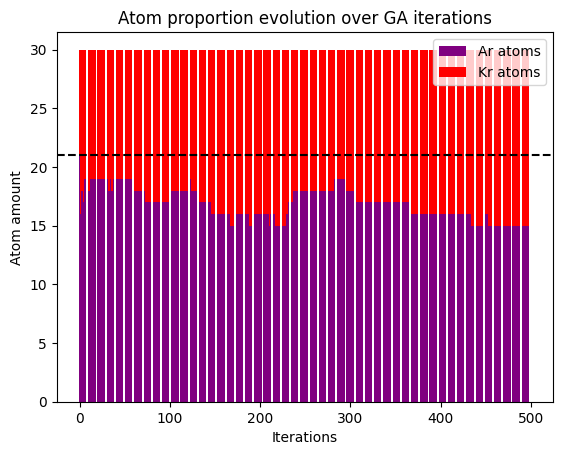

In [40]:
# X-axis positions
x = np.arange(len(ar_nums))

# Plotting the bar plot
fig, ax = plt.subplots()

ax.bar(x, ar_nums, label='Ar atoms', color = "purple")

ax.bar(x, kr_nums, bottom=ar_nums, label='Kr atoms', color = "red")

ax.set_ylabel('Atom amount')
ax.set_xlabel("Iterations")
ax.set_title('Atom proportion evolution over GA iterations')
ax.legend()
ax.axhline(y=ar_nums[0],linestyle='--',c="black")

Kr atoms are larger and more polarizable than Ar atoms, leading to slightly stronger van der Waals attractions between Kr atoms compared to Ar atoms or Ar-Kr pairs.

We expected the larger and more polarizable Kr atoms to occupy a core region with Ar atoms forming a shell around them. This is because Kr-Kr interactions are stronger, so clustering Kr atoms minimizes the system's energy.

By chosing the parent with a probability related to its energy value, we're favoring more the rationale explained before, for this reason mutations to Kr are more frequent, since the algorithm is trying to minimize the LJ potential. 

By making more mutations, is able to form the core composed of Kr and the shell of Ar atoms.

In [1]:
from IPython.display import Image, display, HTML

# Paths to the images
img2 = 'probcross.gif'
img2_path = 'GA no prob.gif'

# HTML code to display images side by side with titles
html_code = f"""
<div style="display: flex; align-items: flex-start;">
    <div style="text-align: center;">
        <img src="{img2_path}" alt="Image 2">
    </div>
    <div style="text-align: center;">
        <img src="{img2}" alt="Image 2">
    </div>
</div>
"""

# Display the images
display(HTML(html_code))


### Caveats of the Genetic Algorithms
GA is a powerful heuristic, however, as any algorithms has some caveats.

First things first, is extremely **computationaly expensive**, particularly for large problems, where the PES is complex.
Evaluating the fitness function for each individual in the generation is already time consuming for a reasonable amount of population and system size.
Indeed, LJ calculation is $O(n^2)$ (cut-off reduces this complexity). 
At the same time, keeping a low amount of individual per generation, decrease the diversity of the generation[9], getting the optimization process into a local optimum[10]. This chance is already high, since we're navigating into an energy landscape with several local minima.

There isn't any stopping criteria specific for any problem, and a very deep knowledge of the problem is needed to understand when to stop the optimization. At the same time including such a prior-knowledge is against the philosophy of the algorithm.

Moreover, there aren't standard crossover and mutation operators, more extensive research should be done to understand the best operator for this specific problem. At the same time, they could require even more computations, increasing the (already high) computation resources needed. Also, designing ad hoc operators that produce better offspring while or improving energy configurations is very challenging. [11]


Last but not least, optimizing LJ clusters requires a delicate balance between exploration (searching new areas of the solution space) and exploitation (refining existing solutions) [12].
A naive approach that one could think immediately is to scale adaptively the parameters to reduce the exploration of the PES after some iterations. However, this would introduce external heuristics (again) that would in a way limit the potential generalization of the algorithm.
For this reason, an approach more exploitative, but not biased by previous knowledge has been implemented.

But first a briefly introduction of another piece of the algorithm is needed.

### Simulated Anneling 
Simulated Annealing (SA) is an optimization technique inspired by the annealing process in metallurgy, where a material is heated and then slowly cooled to remove defects and optimize its structure. The method is particularly useful for finding an approximate global minimum in a large search space where the objective function may have many local minima.
Key Concepts:

* **Neighborhood**: The set of solutions reachable from the current solution by a small perturbation.
* **Temperature**: Represents the control parameter that gradually decreases during the process. High temperature allows the algorithm to explore the search space more freely, while low temperature reduces the probability of accepting worse solutions.
* **Acceptance Probability**: Determines whether to accept a worse solution. 


Let $\Delta E$ be the change of energy from the previous step, and $T$ the current temperature.

Pseudocode:
1. Set a random initial solution
2. $T = \text{high} $
3. Iteratively:
    1. Update (in a general way) the new state to be a small perturbation of the previous state.
    2. Calculate the change in energy ( $\Delta E $)
        1. If the new state is better ($\Delta E  < 0$ ), accept it: is the new solution.
        2. If the new state is worse, accept it if: sampling a uniform at random $ random(0,1)<p = e^{-\frac{\Delta E}{T}}$
    3. $ T = \text{reduceTemperature}(T) $
4. Stopping criteria

Important remarks: 
The acceptance probability will be gradually lower the more the iterations. First iterations are more prone to accept bad solutions, while later iterations will have less chance to accpet. 
The reduction of the temperature must be as slow as possible: the rationale is because the probability distribution of the current state must be in thermodynamic equilibrium at all times.

Unfortunately, the time one must wait for the equilibrium to be restored after a change in temperature, heavily depends on the energy landscape, in a very complicated way. 


Note the analogy of the acceptance criteria with the transitions of a physical system; it corresponds to the Metropolis–Hastings algorithm.

### State of the art SA for MD
Step 3.A is typically implemented using an integration algorithm (like Verlet): letting the system evolve for a small time step (1 or 2fs for classical MD or 10-20fs for coarse-grain MD), and then measuring the potential of the system in the new state, with the same procedure previously explained.
Annealing schedule is problem-dependent, and there isn't a way to assess it, therefore software provides options to choose from Exponential, Linear or sigmoidal.

### Proposed SA for LJ cluster optimization
By using Simulated Annealing with random perturbations as state updates, a more "unbiased" exploration of the potential energy landscape of the Ar-Kr cluster can be performed, potentially finding lower-energy configurations that might be missed by more deterministic methods like Verlet integration (which instead is more appropriate for full FF simulations). 

Moreover, a simplistic random move is computationally cheaper than a numerical integration method.

In [42]:
def simulated_annealing(grid, atom_positions, atom_types, LJ_params, voxel_size, initial_temp, cooling_rate, num_iterations, folder_name="pickles_SA/iteration"):
    current_positions = atom_positions[:]
    current_potential = total_lennard_jones_potential(current_positions, atom_types, LJ_params, voxel_size)
    best_positions = current_positions[:]
    best_potential = current_potential
    temperature = initial_temp
    random.seed(119)
    history_lj = []

    for iteration in range(num_iterations):
        new_positions = current_positions[:]
        # Randomly select an atom and move it to a new position
        atom_index = random.randint(0, len(new_positions) - 1)
        new_x, new_y, new_z = random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        
        # Ensure the new position is not already occupied
        while grid[new_x, new_y, new_z] != 0:
            new_x, new_y, new_z = random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        
        # Move atom to the new position
        old_x, old_y, old_z = new_positions[atom_index]
        new_positions[atom_index] = (new_x, new_y, new_z)

        # Update grid
        grid[old_x, old_y, old_z] = 0
        grid[new_x, new_y, new_z] = 1

        # Calculate the new potential
        new_potential = total_lennard_jones_potential(new_positions, atom_types, LJ_params, voxel_size)
        
        # Acceptance criterion
        delta_potential = new_potential - current_potential
        if delta_potential < 0 or random.uniform(0, 1) < math.exp(-delta_potential / temperature):
            current_positions = new_positions
            current_potential = new_potential
            if new_potential < best_potential:
                best_positions = new_positions[:]
                best_potential = new_potential
        else:
            # Revert the move if not accepted
            grid[new_x, new_y, new_z] = 0
            grid[old_x, old_y, old_z] = 1

        # Decrease the temperature
        temperature *= cooling_rate
        
        if iteration % 10 == 0:
            print(f"Iteration: {iteration}: LJ potential {current_potential}, temperature: {temperature}")
            history_lj.append(current_potential)
        
        if iteration % 100 == 0:
            np.save(folder_name + str(iteration), np.array(current_positions))  

    return best_positions, best_potential, history_lj

In [53]:
# Parameters for the simulated annealing
initial_temp = 1.0
cooling_rate = 0.99
num_iterations = 5000
num_atoms = 30

random.seed(119)
# Initialize the grid
grid, atom_positions, atom_types = initialize_grid(grid_size, num_atoms)

np.save("pickles_SA/type.npy", np.array(atom_types))

# Run simulated annealing
best_positions, best_potential, history_lj = simulated_annealing(grid, atom_positions, atom_types, LJ_params, voxel_size, initial_temp, cooling_rate, num_iterations)

Iteration: 0: LJ potential -0.9219450831971737, temperature: 0.99
Iteration: 10: LJ potential -0.9604933257886725, temperature: 0.8953382542587163
Iteration: 20: LJ potential -0.7398518040864911, temperature: 0.8097278682212583
Iteration: 30: LJ potential -1.1398410679318227, temperature: 0.7323033696543974
Iteration: 40: LJ potential -1.416768656703837, temperature: 0.6622820409839835
Iteration: 50: LJ potential -1.5605710876180268, temperature: 0.5989560064661611
Iteration: 60: LJ potential -1.801493133009874, temperature: 0.5416850759668536
Iteration: 70: LJ potential -1.5467943749162285, temperature: 0.4898902730042049
Iteration: 80: LJ potential -1.9943573140769515, temperature: 0.44304798162617254
Iteration: 90: LJ potential -1.867412619445236, temperature: 0.40068465295154065
Iteration: 100: LJ potential -2.004259050824451, temperature: 0.36237201786049694
Iteration: 110: LJ potential -1.5918765023773545, temperature: 0.3277227574378037
Iteration: 120: LJ potential -1.5546940552

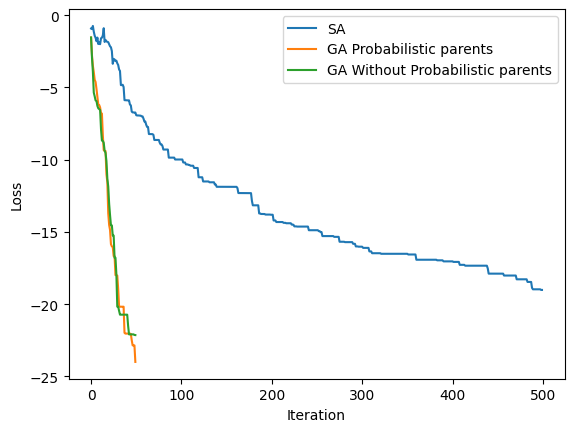

In [84]:
plt.plot(history_lj, label="SA")


plt.plot(history_evolution, label='GA Probabilistic parents')
plt.plot(history_evol_noprob, label='GA Without Probabilistic parents')

plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.legend()

Even though SA needs much more iterations to be compared to GA, they are way cheaper computationally speaking than GA, since are performed on a single individual, while GA uses a whole generation for every step.

To have a sense of the number of moves that GA has performed compared to SA, each iteration correspond to 20 iterations (*generation size*).
So 500 iterations of GA correspond to 500*20=10000 iterations of SA. 

So actually, we performed half iterations with SA, obtaining comparable potential.

Contrary to GA, SA is not changing the types of the intial configurations, but only the positions. So has a more "controlled" optimization: **more exploitative** behaviour.

Therefore in some sense is closer to the direction of expected globabal minima wrt to GA.

In [ ]:
for i in range(0,5000,100):
    gen = np.load("pickles_SA/iteration" + str(i) + ".npy",allow_pickle=True)
    plot_atom_save(gen, atom_types,grid_size, "images_new_SA/iteration" + str(i) + ".png", 150,"Optimized structure by SA")

In [47]:
image_folder = 'images_new_SA'  
output_path = 'SA python.gif'    
create_gif(image_folder, output_path)

GIF created and saved at SA python.gif


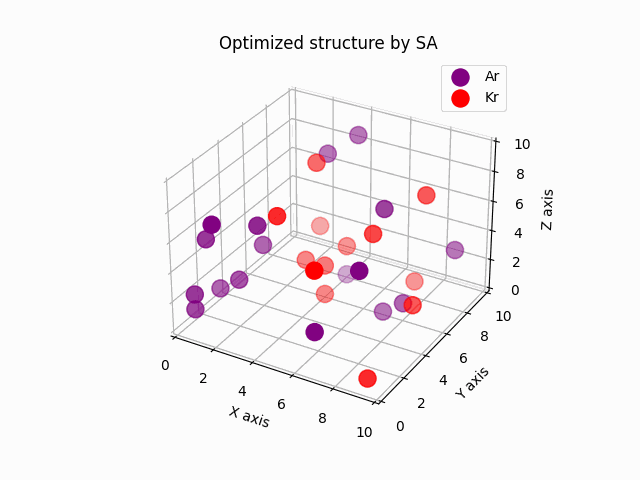

In [3]:
from IPython.display import Image
Image(filename= 'SA python.gif')

#### Cross validating the results obtained with implementation of SA with tinker's implementation of SA.
Same initial configuration is given to both my SA implementation and the tinker's annealing. 

There will be inevitably differences, since the implemented approach uses a random change in position, while Tinker's using Vertlet integration at each time step to perform MD. Moreover, being a stochastic method, the seed is different. However a comparable result should be expected.



Setting box of 36x36x36 A:

In [61]:
import subprocess

result = subprocess.run(["type", "box.key"], shell=True, capture_output=True, text=True)
print(result.stdout)

parameters custom_param.prm

a-axis 36.0
b-axis 36.0
c-axis 36.0
alpha 90.0
beta 90.0
gamma 90.0



My small force field parametrization, using Amber-FF considering only Lennard Jones with the same parameters used by the algorithms.

In [62]:
result = subprocess.run(["type", "custom_param.prm"], shell=True, capture_output=True, text=True)
print(result.stdout)


      ##############################
      ##                          ##
      ##  Force Field Definition  ##
      ##                          ##
      ##############################


forcefield              AMBER-FF94

vdwtype                 LENNARD-JONES
radiusrule              ARITHMETIC
radiustype              R-MIN
radiussize              RADIUS
epsilonrule             GEOMETRIC
vdw-14-scale            2.0
chg-14-scale            1.2

      #############################
      ##                         ##
      ##  Literature References  ##
      ##                         ##
      #############################


[rutkai et al](https://pubs.acs.org/doi/10.1021/acs.jpclett.2c02004)
[White et al for Ar atom]


      #############################
      ##                         ##
      ##  Atom Type Definitions  ##
      ##                         ##
      #############################


atom          3    3    Ar    "Argon Atom Ar"               18    39.948    0
atom        

Tinker's anneal on the initial system configuration randomly generated in the python version, and converting into xyz file.
In this way the same starting system is passed to both algorithms.

In [63]:
grid = np.load("pickles_SA/iteration0.npy" ,allow_pickle=True)
type = np.load("pickles_SA/type.npy" ,allow_pickle=True)

In [100]:
# Export the grid to an XYZ file
def export_to_xyz(filename, atom_positions, atom_types, voxel_size, atom_type_numbers):
    with open(filename, 'w') as file:
        file.write(f"{len(atom_positions)}\t-\tKrAr System\n")
        cnt = 1
        for atom_type, (x, y, z) in zip(atom_types, atom_positions):
            atom_number = atom_type_numbers[atom_type]
            file.write(f"{cnt} {atom_type}\t{x * voxel_size:.3f}\t{y * voxel_size:.3f}\t{z * voxel_size:.3f}\t{atom_number}\n")
            cnt = cnt + 1

In [66]:
# Lennard-Jones atom types used in FF
atom_type_numbers = {
    'Ar': 3,
    'Kr': 4
}
grid, atom_positions, atom_types = initialize_grid(grid_size, num_atoms)
export_to_xyz("atoms.xyz", atom_positions, atom_types, voxel_size, atom_type_numbers)

#### Tinker anneal with custom FF
./anneal atoms.xyz -k box.key

The annealing procedure is configured trying to replicate the same settings of the python implementation:
* Exponential cooling, with same temperature range [1.0, 1.641558016697225e-22]
* 5000 steps
* Time Step Length: 10 fs (typical time step of coarse simulations, like MARTINI. Since in my python implementation i moved randomly an atom by any distance, I supposed is reasonable to set a quite high time step)
* Saves every 0.1 ps

That is a simulation of 50 ns. A timestep of 10 fs is reasonable since vibrations and bendings aren't modeled.

Obtaining:
* Potential:       -19.9048 Kcal/mole
* Current Kinetic: 0.5753 Kcal/mole

Against my implementations:
* SA Potential:       -19.012637 Kcal/mole
* GA Potential:       -24.00329 Kcal/mole

The tinker implementation is finding a similar minimum energy value with my SA implementation, using same amount of iterations. 

My implementation of GA is finding a way lower energy (-5 kcal/mol with respect to both version of SA). However we can't really convert the amount of iterations of GA with the ones of SA.

A utility function to process arc files to be read with vmd.

In [70]:
def process_file(input_file_path, output_file_path):
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        lines = infile.readlines()
        
        # Modify the header line
        header = lines[0].split()
        outfile.write(f"{header[0]}\n")

        flag = False
        # Process each remaining line
        for line in lines[2:]:
            parts = line.split()

            if float(parts[0]) == 36.:
                continue
            
            if float(parts[0]) == 30 and flag == False:
                filtered_parts = parts[1:-1]
                outfile.write(f"{parts[-1]} ")
                outfile.write(f"{' '.join(filtered_parts)}\n")
                flag = True
                continue
            
            if float(parts[0]) != 30.:
                # Remove the first and last columns
                filtered_parts = parts[1:-1]
                outfile.write(f"{parts[-1]} ")
                outfile.write(f"{' '.join(filtered_parts)}\n")
            else:
                outfile.write(f"{parts[0]}\n")
                flag = False

In [159]:
grid, atom_positions, atom_types = initialize_grid(grid_size, num_atoms)
atom_positions = np.load("pickles_SA/iteration4900.npy", allow_pickle=True)
type           = np.load("pickles_SA/type.npy",          allow_pickle=True)

In [160]:
# Lennard-Jones atom types used in FF
atom_type_numbers = {
    'Ar': 3,
    'Kr': 4
}
export_to_xyz("atoms_my_SA.xyz", atom_positions, type, voxel_size, atom_type_numbers)

In [163]:
from IPython.display import Image, display, HTML

# Paths to the images
img2 = 'atoms_my_SA.png'
img2_path = 'annealing tinker.png'

# HTML code to display images side by side with titles
html_code = f"""
<div style="display: flex; align-items: flex-start;">
    <div style="text-align: center;">
        <h3>My annealing version</h3>
        <img src="{img2}" alt="Image 2">
        <h4> -19.012637 Kcal/mole</h4>
    </div>
    <div style="text-align: center;">
        <h3>Tinker annealing</h3>
        <img src="{img2_path}" alt="Image 2">
        <h4> -19.9048 Kcal/mole</h4>
    </div>
</div>
"""

# Display the images
display(HTML(html_code))


Even though the tinker's SA led to a conformation with nearly 1kcal/mol lower energy, my SA implementation has a single well separated cluster, while the tinker's implementations has a big not compact cluster and a small second one.

The compactness of the cluster may be due to the coarse voxel grid used: representing a voxel grid per atom is in some way fixing the position of the atoms, leaving less degree of freedom than the true conformations.

I believe that the result obtained is a **combination** of both the **voxel grid** **and** the **randomistic move of the annealing** compared to the Vertlet integration of motion used by tinker. 

To be more specific: a random move of the SA in the iteration is moving a random atom by a random position of no more than 3.6 Å, while the optimal move may be less than the radius of the atom.
At the same time, using a more refined voxel grid, like 1 Å per voxel (or 0.5 Å that is a typical voxel used in docking), comport heavier computations (still less than using floating point coordinates).

We're in some way limiting the degrees of freedom, allowing to reach a minimum energy confomation with less iterations.


./anneal atom.xyz -k box.key

In [71]:
input_file_path = "atoms.arc"
output_file_path = "atomsvmd.arc"

process_file(input_file_path, output_file_path)

The full animation can be seen in VMD as a movie, but is not relevant for the analysis.

### GASA
The idea behind the proposed heuristic is to combine the strength of the GA with the strength of the SA to reduce the downside of both algorithms.
On one hand SA doesn't include any mutation on the system, leaving proportion of the two atom types inalterated from the initial configuration, while in computational discovery techniques (like drug/material discovery), it may be useful to not include any constraints to obtain a more general (not yet observed) system.

On the other hand, GA lacks of the ability to escape local minima without altering too much the system. (GA indeed can actually overcome barriers at price of more mutations, but at some point is not anymore reasonable to alter the system that much).

An initial **broad exploration with GA** is performed, with a **low number of iteration** (80) **to not fall into the local minima** and change too much the initial system.
The generation size is instead increased to 30 to increase the diversity and the depth of exploration.
The **final refinement search on the PES** is done **with SA** that is able **to escape high energy barriers**.



This hybrid approach combines the global search capabilities of GA with the local search efficiency of SA.
With the proposed method, we aim to reach a good balance between exploration and exploitation, with SA helping to avoid GA's local minima thorough local searches.


In [86]:
random.seed(119)
num_atoms = 30
best_positions, best_types, best_fitness, history_evolution = genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size, 90, 30, 0, "GASA/iteration")
print(f"Best solution: {best_positions}")
print(f"Atom types: {best_types}")
print(f"Best Lennard-Jones potential: {best_fitness}")

generation 0: fitness: -1.7698123983077767
generation 10: fitness: -2.9577876595162804
generation 20: fitness: -3.7004421358376707
generation 30: fitness: -4.613796531701353
generation 40: fitness: -4.946827893406842
generation 50: fitness: -5.549341156813559
generation 60: fitness: -6.0804977488824115
generation 70: fitness: -6.5814542523410955
generation 80: fitness: -6.884738288794759
Best solution: [(9, 8, 3), (7, 4, 7), (7, 5, 7), (6, 6, 8), (4, 7, 9), (7, 6, 9), (7, 6, 5), (8, 8, 2), (3, 7, 9), (6, 3, 3), (7, 3, 4), (6, 7, 7), (9, 3, 7), (7, 7, 8), (8, 9, 0), (7, 8, 3), (7, 8, 2), (8, 8, 2), (7, 5, 6), (6, 5, 5), (6, 7, 8), (6, 6, 6), (8, 8, 2), (6, 7, 7), (6, 6, 7), (7, 4, 6), (8, 6, 5), (8, 6, 6), (7, 5, 3), (7, 3, 3)]
Atom types: ['Ar', 'Ar', 'Kr', 'Kr', 'Ar', 'Kr', 'Ar', 'Kr', 'Ar', 'Kr', 'Ar', 'Ar', 'Kr', 'Kr', 'Kr', 'Kr', 'Ar', 'Kr', 'Kr', 'Kr', 'Kr', 'Kr', 'Ar', 'Ar', 'Ar', 'Kr', 'Kr', 'Ar', 'Kr', 'Ar']
Best Lennard-Jones potential: -6.949346588390615


The initial temperature is lower wrt to plain SA. Using a rule of thumb was set to $100$*temperature of the last GA's iteration loss's from plain SA.

The rationale is that we must accept less worst solutions, since we're already in a better point on the PES (we're coming already from a broad optimization!), and this phase is intended more as a refinement search than an optimization.

In [87]:
initial_temp = 0.001
cooling_rate = 0.99
num_iterations = 5000
num_atoms = 30

random.seed(119)
# Get grid
grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)

for pos in best_positions:
    x, y, z = pos
    grid[x, y, z] = 1

np.save("GASA/type.npy", np.array(best_types))
# Run simulated annealing
best_positions, best_potential, history_lj = simulated_annealing(grid, best_positions, best_types, LJ_params, voxel_size, initial_temp, cooling_rate, num_iterations,
                                                                 folder_name ="GASA/SAiteration")


Iteration: 0: LJ potential -6.949346588390615, temperature: 0.00099
Iteration: 10: LJ potential -6.949346588390615, temperature: 0.0008953382542587163
Iteration: 20: LJ potential -6.949346588390615, temperature: 0.0008097278682212583
Iteration: 30: LJ potential -7.0406797660483385, temperature: 0.0007323033696543973
Iteration: 40: LJ potential -7.282165408176333, temperature: 0.0006622820409839833
Iteration: 50: LJ potential -7.3609961722156765, temperature: 0.0005989560064661609
Iteration: 60: LJ potential -7.370421666357902, temperature: 0.0005416850759668536
Iteration: 70: LJ potential -7.546005667056285, temperature: 0.0004898902730042048
Iteration: 80: LJ potential -7.546005667056285, temperature: 0.0004430479816261725
Iteration: 90: LJ potential -7.546005667056285, temperature: 0.00040068465295154044
Iteration: 100: LJ potential -7.549185677730104, temperature: 0.00036237201786049685
Iteration: 110: LJ potential -7.549185677730104, temperature: 0.00032772275743780374
Iteration: 1

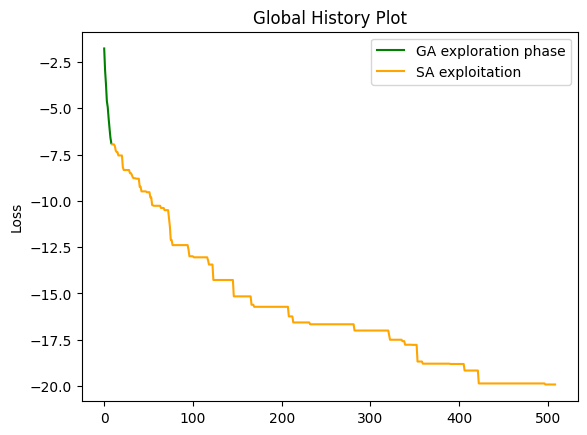

In [90]:
import matplotlib.pyplot as plt
global_history = history_evolution + history_lj
# Plot the first part of the data
plt.plot(range(len(history_evolution)), history_evolution, color='green', label='GA exploration phase')

# Plot the second part of the data
plt.plot(range(len(history_evolution), len(global_history)), history_lj, color='orange', label='SA exploitation')

plt.ylabel('Loss')
plt.title('Global History Plot')
plt.legend()

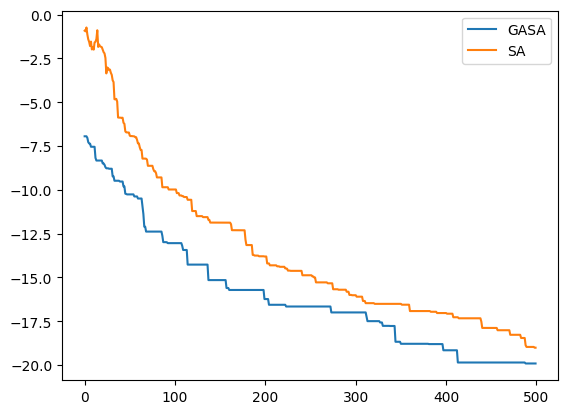

In [74]:
plt.plot(history_lj, label="GASA")
plt.plot(history_lj_plain,label="SA")
plt.legend()

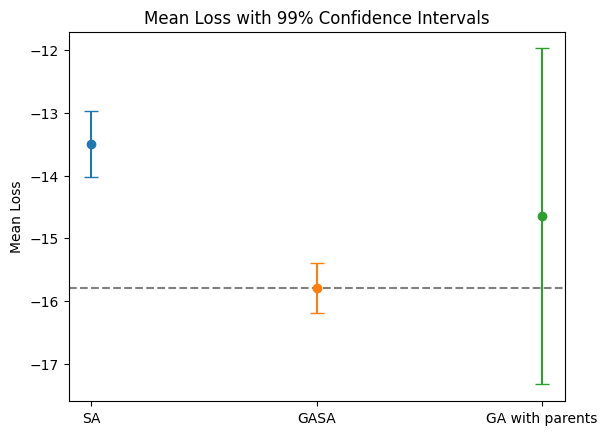

In [94]:
import scipy.stats as stats
# sample of dimension 500 >> 1 -> CLT -> Normality

mean_algo1 = np.mean(global_history)
mean_algo2 = np.mean(history_lj_plain)
mean_algo3 = np.mean(history_GA_parents)
# Standard errors
se_algo1 = stats.sem(history_lj)
se_algo2 = stats.sem(history_lj_plain)
se_algo3 = stats.sem(history_GA_parents)
# 95% confidence intervals
ci_algo1 = se_algo1 * stats.t.ppf((1 + 0.99) / 2., len(history_lj)-1)
ci_algo2 = se_algo2 * stats.t.ppf((1 + 0.99) / 2., len(history_lj_plain)-1) 
ci_algo3 = se_algo3 * stats.t.ppf((1 + 0.99) / 2., len(history_GA_parents)-1)


plt.errorbar(1, mean_algo2, yerr=ci_algo2, fmt='o', label='SA', capsize=5)
plt.errorbar(2, mean_algo1, yerr=ci_algo1, fmt='o', label='GASA', capsize=5)
plt.errorbar(3, mean_algo3, yerr=ci_algo3, fmt='o', label='GA parents', capsize=5)

plt.title('Mean Loss with 99% Confidence Intervals')
plt.ylabel('Mean Loss')
plt.xticks([1, 2,3], ['SA', 'GASA', 'GA with parents'])
plt.axhline(y=mean_algo1, color='grey', linestyle='--')
plt.show()


There is a clear advantage of the GASA wrt to plain SA. The mean energy is significatly lower, at parity of iterations performed.

There isn't a statistical evidence to prefer GASA to genetic algorithm in terms of mean loss (and therefore likelihood to fall into global minima).

However, the conceptual advantage of GASA is not in the ability to reach the minima, but the computation speedup to GA and its ability to stick to a more fixed system, reaching the global minima without changing too many atoms. 


In [ ]:
atom_types = np.load("GASA/type.npy",allow_pickle=True)
for i in range(0,5000,100):
    gen = np.load("GASA/SAiteration" + str(i) + ".npy",allow_pickle=True)
    plot_atom_save(gen, atom_types,grid_size, "GASA/SA/SAiteration" + str(i) + ".png", 150, "Optimized structure by SA iteration: " + str(i))

In [96]:
image_folder = 'GASA/SA'  
output_path = 'GASA_SA_part.gif'     
create_gif(image_folder, output_path)

GIF created and saved at GASA_SA_part.gif


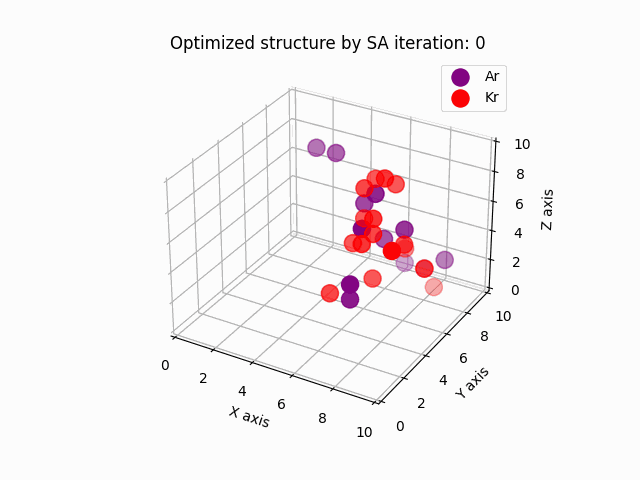

In [4]:
from IPython.display import Image
Image(filename= 'GASA_SA_part.gif'   )

./minimize atoms.xyz -k box.key

In [98]:
from IPython.display import Image,display, HTML
Image(filename= 'minimized_tinker.png')

# Paths to the images
img2 = 'minimized_tinker.png'

# HTML code to display images side by side with titles
html_code = f"""
<div style="display: flex; align-items: flex-start;">
    <div style="text-align: center;">
        <h3>Tinker minimized system</h3>
        <img src="{img2}" alt="Image 2">
        <h4> -34.3554 Kcal/mole</h4>
    </div>
</div>
"""

# Display the images
display(HTML(html_code))


The results accords to our hypothesis and with the minimized structure using Tinker (with my parametrization of AMBER94): Kr is occupying more core positions, while Ar is shielding the cluster. 

### Final test: a more specific initalization 
As last proof of concept, a more specific initalization of the system is tested, to remark that the random initialization is not a requirement of none of the algorithms.

In [113]:
def initialize_fcc_grid(grid_size,blocks=2):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)
    atom_positions = []
    atom_types = []  # Track the type of each atom
    num_atoms = 0
    dist = 2
    two_dist = 2*dist
    fcc_positions = [
        (0,    0,    0),
        (0,    dist, dist),
        (dist, 0,    dist),
        (dist, dist, 0),
        (two_dist,  dist, dist),
        (dist, two_dist,   dist),
        (dist, dist,  two_dist),
        (two_dist,  two_dist,  0), 
        (two_dist,  0,    two_dist), 
        (0,    two_dist,  two_dist),
        (0,    two_dist,  0), 
        (two_dist,  0,    0), 
        (0,    0,    two_dist), 
        (two_dist,  two_dist,  two_dist)
    ]
    old = fcc_positions[:]
    for pos in old:
        x,y,z = pos[0] + dist,pos[1] + dist,pos[2] + dist
        fcc_positions.append(( x,y,z))
    
    for pos in fcc_positions:
        atom_types.append(random.choice(['Ar', 'Kr']))  # Randomly assign Ar or Kr to each position
        num_atoms += 1
    return grid, fcc_positions, atom_types


In [ ]:
grid, pos, atom_t= initialize_fcc_grid(grid_size)
plot_atom_save(pos, atom_t, grid_size, "zzz.png")

# Lennard-Jones atom types
atom_type_numbers = {
    'Ar': 3,
    'Kr': 4
}

export_to_xyz("fcc_initialization.xyz", pos, atom_t, voxel_size, atom_type_numbers)

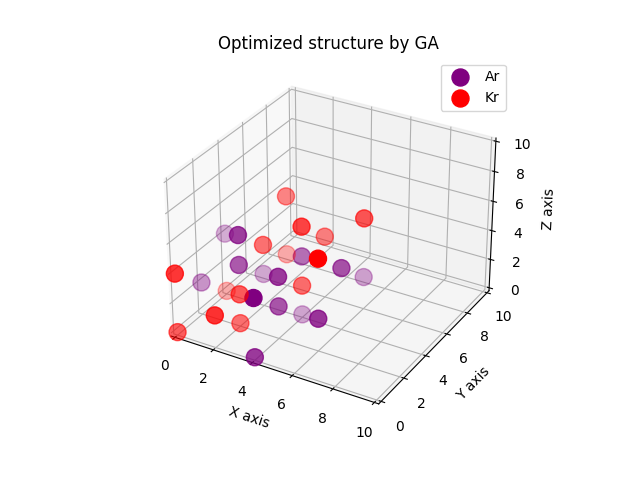

In [5]:
Image(filename= "zzz.png")

Genetic algorithm with random initialization of the FCC grid.

In [149]:
ar_nums = []
kr_nums = []
# Genetic Algorithm for optimization
def genetic_algorithm_fcc(grid_size, num_atoms, LJ_params, voxel_size, num_generations, population_size, version, folder_name):
    # Initialize population
    population = [initialize_fcc_grid(grid_size, 2) for _ in range(population_size)]
    history_evolution = []
    
    for generation in range(num_generations):

        # Calculate fitness
        fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]

        # Selection
        fitness_population = sorted(zip(fitness, population), key=lambda x: x[0])
        population = [x[1] for x in fitness_population[:population_size//selection_percentage]]
        if generation % 10 == 0:
            print("generation {}: fitness: {}".format(generation, min(fitness)))
            history_evolution.append(population[0])
            pop_npy = np.array(population[0],dtype=object)
            if version == 0:
                np.save(folder_name+ str(generation), pop_npy)
            else:
                np.save("pickles_probcross/iteration"+ str(generation), pop_npy)
            ar_nums.append(population[0][2].count("Ar"))
            kr_nums.append(population[0][2].count("Kr"))  
        
        # Crossover
        new_population = population[:]
        # crossover version 1
        if version == 0:
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(population, 2)
                crossover_point = random.randint(0, num_atoms-1)
                child_positions = parent1[1][:crossover_point] + parent2[1][crossover_point:]
                child_types = parent1[2][:crossover_point] + parent2[2][crossover_point:]
                new_population.append((None, child_positions, child_types))
        else: # crossover version 2
            alpha = []
            for p in range(len(population)):
                alpha.append(fitness[p])
            alpha = alpha / sum(alpha)
            
            while len(new_population) < population_size:
                parent1, parent2 = random.choices(population,
                                                  weights = alpha, 
                                                  k = 2)
                crossover_point = random.randint(0, num_atoms-1)
                child_positions = parent1[1][:crossover_point] + parent2[1][crossover_point:]
                child_types = parent1[2][:crossover_point] + parent2[2][crossover_point:]
                new_population.append((None, child_positions, child_types))
            
        
        # Mutation
        for individual in new_population:
            if random.random() < mutation_probability:  # Mutation probability
                idx = random.randint(0, num_atoms-1)
                individual[1][idx] = (random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1))
                individual[2][idx] = random.choice(['Ar', 'Kr'])  # Randomly assign new type
        
        population = new_population
    
    # Get the best solution
    fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]
    best_solution = population[np.argmin(fitness)]

    return best_solution[1], best_solution[2], np.min(fitness), history_evolution

In [150]:
num_atoms = 28

In [151]:
best_positions, best_types, best_fitness, history_evolution = genetic_algorithm_fcc(grid_size, num_atoms, LJ_params, voxel_size, 80, 30, 0, "pickles_GASA_fcc/iteration")
print(f"Best solution: {best_positions}")
print(f"Atom types: {best_types}")
print(f"Best Lennard-Jones potential: {best_fitness}")

generation 0: fitness: -0.5697105660189897
generation 10: fitness: -2.2995763266424105
generation 20: fitness: -2.7321096220086947
generation 30: fitness: -3.483471476344656
generation 40: fitness: -4.2679997411802875
generation 50: fitness: -4.321432355745971
generation 60: fitness: -5.1944765919377796
generation 70: fitness: -5.775537597276812
Best solution: [(0, 0, 0), (3, 2, 5), (0, 6, 3), (1, 6, 3), (5, 4, 3), (2, 4, 2), (2, 2, 4), (4, 4, 0), (5, 3, 4), (4, 4, 1), (4, 4, 0), (4, 3, 0), (2, 1, 4), (4, 4, 4), (2, 2, 2), (2, 4, 4), (1, 5, 2), (4, 4, 2), (3, 5, 4), (2, 5, 1), (4, 3, 5), (3, 5, 1), (3, 5, 4), (1, 2, 6), (2, 6, 2), (4, 3, 0), (2, 2, 6), (5, 3, 3)]
Atom types: ['Kr', 'Kr', 'Ar', 'Ar', 'Ar', 'Kr', 'Kr', 'Ar', 'Ar', 'Ar', 'Ar', 'Ar', 'Ar', 'Kr', 'Kr', 'Kr', 'Kr', 'Ar', 'Kr', 'Ar', 'Ar', 'Ar', 'Ar', 'Ar', 'Kr', 'Ar', 'Ar', 'Kr']
Best Lennard-Jones potential: -5.988384886929227


In [131]:
initial_temp = 0.001
cooling_rate = 0.9
num_iterations = 5000

random.seed(119)
# Get grid
grid = np.zeros((grid_size, grid_size, grid_size), dtype=int)

for pos in best_positions:
    x, y, z = pos
    grid[x, y, z] = 1

np.save("pickles_GASA_fcc/type.npy", np.array(best_types))
# Run simulated annealing
best_positions, best_potential, history_lj = simulated_annealing(grid, best_positions, best_types, LJ_params, voxel_size, initial_temp, cooling_rate, num_iterations,
                                                                 folder_name ="pickles_GASA_fcc/SAiteration")

Iteration: 0: LJ potential -9.027837702784108, temperature: 0.0009000000000000001
Iteration: 10: LJ potential -9.027837702784108, temperature: 0.00031381059609000004
Iteration: 20: LJ potential -9.186387174366414, temperature: 0.00010941898913151243
Iteration: 30: LJ potential -9.186387174366414, temperature: 3.8152042447694614e-05
Iteration: 40: LJ potential -9.186387174366414, temperature: 1.3302794647291146e-05
Iteration: 50: LJ potential -9.186387174366414, temperature: 4.638397686588108e-06
Iteration: 60: LJ potential -9.186387174366414, temperature: 1.6173092699229909e-06
Iteration: 70: LJ potential -9.186387174366414, temperature: 5.639208733960183e-07
Iteration: 80: LJ potential -9.186387174366414, temperature: 1.966270504755533e-07
Iteration: 90: LJ potential -9.379933317653325, temperature: 6.85596132412799e-08
Iteration: 100: LJ potential -9.379933317653325, temperature: 2.3905258998828786e-08
Iteration: 110: LJ potential -9.48730811764373, temperature: 8.33524841789811e-09


In [ ]:
for i in range(0,100,10):
    gen = np.load("pickles_GASA_fcc/GA/iteration" + str(i) + ".npy",allow_pickle=True)
    plot_atom_save(gen[1],gen[2],grid_size, "images_GASA_fcc/GAiteration" + str(i) + ".png",70,"Optimized structure by GA")

In [ ]:
for i in range(0,5000,100):
    gen = np.load("pickles_GASA_fcc/SA/SAiteration" + str(i) + ".npy",allow_pickle=True)
    plot_atom_save(gen, best_types,grid_size, "images_GASA_fcc/iteration" + str(i) + ".png",70,"Optimized structure by SA")

#### Broad search by GA

In [133]:
image_folder = 'images_GASA_fcc/GA'  
output_path = 'GASA_GA_part_fcc.gif'    
create_gif(image_folder, output_path)


GIF created and saved at GASA_GA_part_fcc.gif


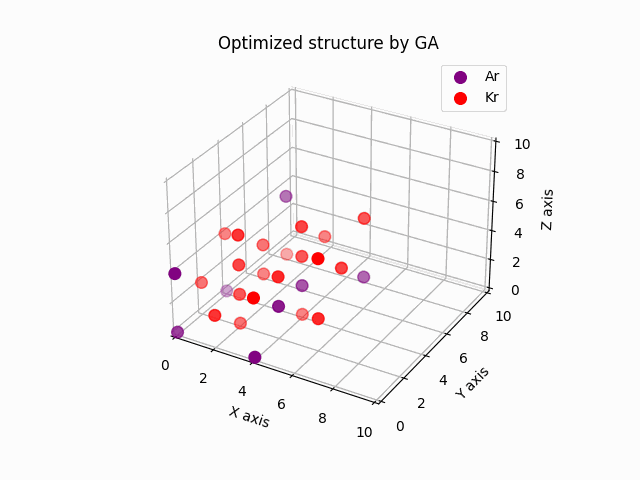

In [6]:
from IPython.display import Image
Image(filename= "GASA_GA_part_fcc.gif")

Notice how lots of atoms have been mutated in order to try to increment the number of Ar in order to a balanced system.

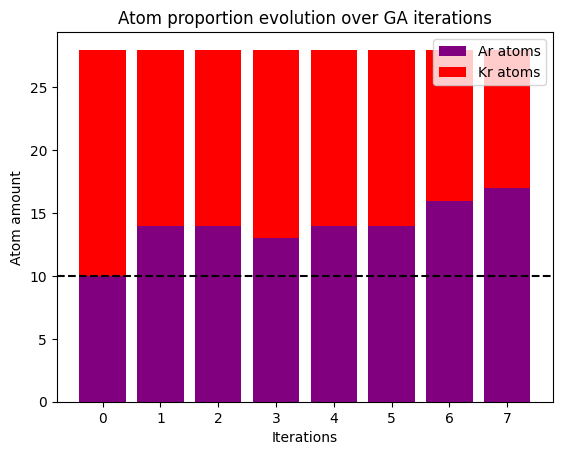

In [152]:
# X-axis positions
x = np.arange(len(ar_nums))

# Plotting the bar plot
fig, ax = plt.subplots()

ax.bar(x, ar_nums, label='Ar atoms', color = "purple")

ax.bar(x, kr_nums, bottom=ar_nums, label='Kr atoms', color = "red")

ax.set_ylabel('Atom amount')
ax.set_xlabel("Iterations")
ax.set_title('Atom proportion evolution over GA iterations')
ax.legend()
ax.axhline(y=ar_nums[0],linestyle='--',c="black")

### Refinement search by SA

In [135]:
image_folder = 'images_GASA_fcc/SA'  
output_path = 'GASA_SA_part_fcc.gif'    
create_gif(image_folder, output_path)

GIF created and saved at GASA_SA_part_fcc.gif


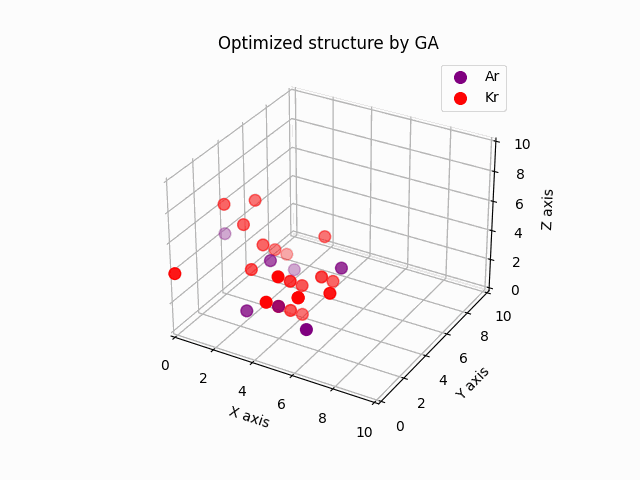

In [158]:
from IPython.display import Image
Image(filename= "GASA_SA_part_fcc.gif")

In [137]:
export_to_xyz("fcc_minimized.xyz", gen, best_types, voxel_size, atom_type_numbers)

In [144]:
from IPython.display import Image, display, HTML

# Paths to the images
img2 = 'vmd minimized fcc.png'
img2_path = 'tinker minimized fcc.png'

# HTML code to display images side by side with titles
html_code = f"""
<div style="display: flex; align-items: flex-start;">
    <div style="text-align: center;">
        <h3>My annealing version</h3>
        <img src="{img2}" alt="Image 2">
        <h4> -19.2178 Kcal/mole</h4>
    </div>
    <div style="text-align: center;">
        <h3>Tinker annealing</h3>
        <img src="{img2_path}" alt="Image 2">
        <h4> -7.1760 Kcal/mole</h4>
    </div>
</div>
"""

# Display the images
display(HTML(html_code))


In [147]:
best_types.count("Kr")

16

In [148]:
best_types.count("Ar")

12

The standard minimization algorithm by tinker has a similar structures of the GASA's output, but regarding the amount of atoms, the GASA's miminimzed structure has a balanced amount of atoms between Ar and Kr. This is what is typically needed for instance in material discoveries.

More deterministic approach wouldn't be able to "capture" such an unbalance. The broad exploration of GA instead allowed to fix the proportion of atoms, giving a way lower minimum energy.

#### Conclusion
The integration of genetic algorithms with simulated annealing proved to be an effective strategy for optimizing Lennard-Jones clusters. This approach successfully combined the strengths of both methods.

An important consideration is that all algorithm are suited only for Lennard Jones cluster optimization, and not intended for full FF systems, since random perturbations can't be performed due to presence of atoms.

Future works could explore scaling this method to larger systems, using other atoms or use alternative initialization strategies and more sophisticated genetic operators. Also calibrating more accurately the amount of iterations to do for both the algorithms in the GASA via cross validation (if more computational resources are available).

### Bibliography

[1] Genetic algorithms for computational materials discovery accelerated by machine learning, P. C. Jennings et al. \
[2] Curless, B., & Levoy, M. (1996). A Volumetric Method for Building Complex Models from Range Images.\
[3] Holland, J. H. (1992). Adaptation in Natural and Artificial Systems: An Introductory Analysis with Applications to Biology, Control, and Artificial \Intelligence. MIT Press. 
[4] Lide, D. R. (Ed.). (2005). CRC Handbook of Chemistry and Physics (86th ed.).\
[5] Goldberg, D. E. (1989). Genetic Algorithms in Search, Optimization, and Machine Learning. Addison-Wesley.\
[6]  Syswerda, Gilbert (1989), Schaffer, J.D. (ed.), "Uniform crossover in genetic algorithms", Proceedings of the 3rd International Conference on Genetic Algorithms (ICGA), San Francisco: Morgan Kaufmann.\
[7] https://en.wikipedia.org/wiki/Genetic_algorithm\
[8] De Jong, K. A. (1975). Analysis of the behavior of a class of genetic adaptive systems. PhD Thesis, University of Michigan.\
[9] Eiben, A. E., & Smit, S. K. (2011). Parameter tuning for configuring and analyzing evolutionary algorithms. Swarm and Evolutionary Computation.\
[10] Mitchell, M. (1998). An Introduction to Genetic Algorithms. MIT.\
[11] Wales, D. J., & Doye, J. P. K. (1997). Global optimization by Basin-Hopping and the Lowest Energy Structures of Lennard-Jones Clusters Containing up to 110 Atoms. The Journal of Physical Chemistry A.\
[12] Deb, K. (2001). Multi-Objective Optimization using Evolutionary Algorithms. John Wiley & Sons. 


### Extra: benchmark

In [153]:
import time

In [154]:
# Genetic Algorithm for optimization
def genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size, num_generations=500, population_size=20, version=0):
    # Initialize population
    population = [initialize_grid(grid_size, num_atoms) for _ in range(population_size)]
    history_evolution = []
    
    for generation in range(num_generations):

        # Calculate fitness
        fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]

        # Selection
        fitness_population = sorted(zip(fitness, population), key=lambda x: x[0])
        population = [x[1] for x in fitness_population[:population_size//selection_percentage]]
                
        # Crossover
        new_population = population[:]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population, 2)
            crossover_point = random.randint(0, num_atoms-1)
            child_positions = parent1[1][:crossover_point] + parent2[1][crossover_point:]
            child_types = parent1[2][:crossover_point] + parent2[2][crossover_point:]
            new_population.append((None, child_positions, child_types))
        
        # Mutation
        for individual in new_population:
            if random.random() < mutation_probability:  # Mutation probability
                idx = random.randint(0, num_atoms-1)
                individual[1][idx] = (random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1))
                individual[2][idx] = random.choice(['Ar', 'Kr'])  # Randomly assign new type
        
        population = new_population

    
    # Get the best solution
    fitness = [total_lennard_jones_potential(individual[1], individual[2], LJ_params, voxel_size) for individual in population]
    best_solution = population[np.argmin(fitness)]

    return best_solution[1], best_solution[2], np.min(fitness), history_evolution
random.seed(119)
num_atoms = 30


start = time.process_time()
best_positions, best_types, best_fitness, history_evolution = genetic_algorithm(grid_size, num_atoms, LJ_params, voxel_size)
print(time.process_time() - start)


12.25


In [156]:
def simulated_annealing(grid, atom_positions, atom_types, LJ_params, voxel_size, initial_temp, cooling_rate, num_iterations):
    current_positions = atom_positions[:]
    current_potential = total_lennard_jones_potential(current_positions, atom_types, LJ_params, voxel_size)
    best_positions = current_positions[:]
    best_potential = current_potential
    temperature = initial_temp
    history_lj = []

    for iteration in range(num_iterations):
        new_positions = current_positions[:]
        # Randomly select an atom and move it to a new position
        atom_index = random.randint(0, len(new_positions) - 1)
        new_x, new_y, new_z = random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        
        # Ensure the new position is not already occupied
        while grid[new_x, new_y, new_z] != 0:
            new_x, new_y, new_z = random.randint(0, grid_size-1), random.randint(0, grid_size-1), random.randint(0, grid_size-1)
        
        # Move atom to the new position
        old_x, old_y, old_z = new_positions[atom_index]
        new_positions[atom_index] = (new_x, new_y, new_z)

        # Update grid
        grid[old_x, old_y, old_z] = 0
        grid[new_x, new_y, new_z] = 1

        # Calculate the new potential
        new_potential = total_lennard_jones_potential(new_positions, atom_types, LJ_params, voxel_size)
        
        # Acceptance criterion
        delta_potential = new_potential - current_potential
        if delta_potential < 0 or random.uniform(0, 1) < math.exp(-delta_potential / temperature):
            current_positions = new_positions
            current_potential = new_potential
            if new_potential < best_potential:
                best_positions = new_positions[:]
                best_potential = new_potential
        else:
            # Revert the move if not accepted
            grid[new_x, new_y, new_z] = 0
            grid[old_x, old_y, old_z] = 1

        # Decrease the temperature
        temperature *= cooling_rate
        
    return best_positions, best_potential, history_lj



# Parameters for the simulated annealing
initial_temp = 1.0
cooling_rate = 0.99
num_iterations = 5000
num_atoms = 30

random.seed(119)
# Initialize the grid
grid, atom_positions, atom_types = initialize_grid(grid_size, num_atoms)
start = time.process_time()
best_positions, best_potential, history_lj = simulated_annealing(grid, atom_positions, atom_types, LJ_params, voxel_size, initial_temp, cooling_rate, num_iterations)
print(time.process_time() - start)

6.09375
